# Flight Delay Prediction

Installing the Tensorflow library to use the functions in Keras <br>
Importing numpy, pandas and matplotlib for data processing and plotting

In [1]:
%%capture
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

Reading the input files from the csv format (after manually unzipping them) and printing the column labels using `train.head()`

In [2]:
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")
subm = pd.read_csv("sample_sub1.csv")

train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Pre-processing the data in the columns of both the testing data and the training data by following the below steps:
<ul>
    <li>Remove the string prefix <b>"c-"</b> from columns: <b>"Month"</b>, <b>"DayOfWeek"</b> and <b>"DayofMonth"</b> and convert them to integers.
    <li>Changing the departure time to departure hour as it seems like a more relevant measure (for business of the airport) than the exact minute for departure.
    <li>Replacing the <b>"dep_dealyed_15min"</b> column values by booleans: <b>'1', '0'</b> instead of <b>"Y", "N"</b>.
    <li>Factorising the string valued columns such as <b>"UniqueCarrier"</b>, <b>"Origin"</b> and <b>"Dest"</b> in order to get unique numbers.
</ul>

In [3]:
# Pre-processing for training data
train["Month"] = [int(month[2:]) for month in train["Month"]]
train["DayofMonth"] = [int(day[2:]) for day in train["DayofMonth"]]
train["DayOfWeek"] = [int(d[2:]) for d in train["DayOfWeek"]]
train["DepHour"] = [int(t/100) for t in train["DepTime"]]

train = train.drop("DepTime", axis=1)
for col in ['Origin', 'Dest', 'UniqueCarrier']:
    train[col] = pd.factorize(train[col])[0]

train["dep_delayed_15min"] = [1  if n == "Y" else 0 for n in train["dep_delayed_15min"]]


# Pre-processing for testing data
test["Month"] = [int(month[2:]) for month in test["Month"]]
test["DayofMonth"] = [int(day[2:]) for day in test["DayofMonth"]]
test["DayOfWeek"] = [int(d[2:]) for d in test["DayOfWeek"]]
test["DepHour"] = [int(t/100) for t in test["DepTime"]]

test = test.drop("DepTime", axis=1)
for col in ['Origin', 'Dest', 'UniqueCarrier']:
    test[col] = pd.factorize(test[col])[0]

Logically the <b>Dist</b>ance that is to be covered by the flight, the <b>Dest</b>ination airport as well as the <b>DayofMonth</b> shouldn't affect the probability of delay as they are variables that either play a very small or no part in the function. <br>
We can now plot the delay output based on each of these parameters and see which ones are to be dropped.

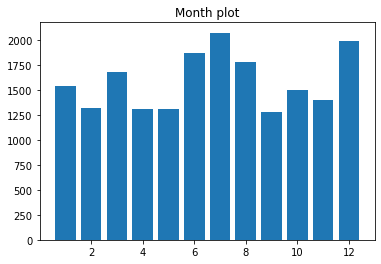

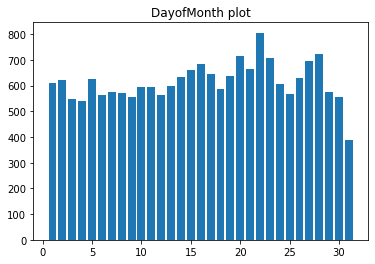

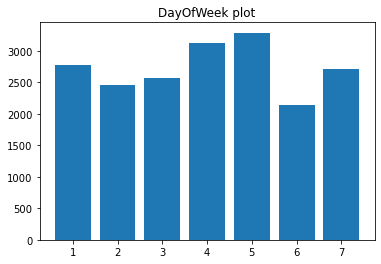

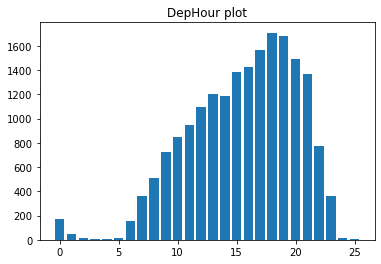

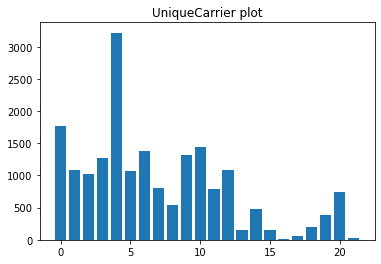

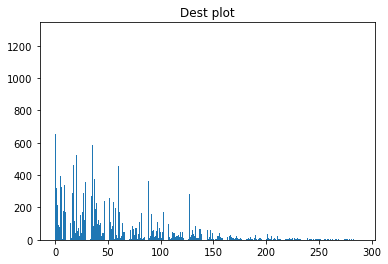

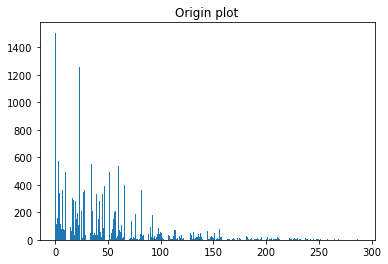

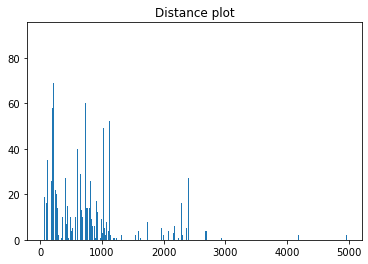

In [4]:
plt.bar(train.groupby("Month")["dep_delayed_15min"].sum().index, train.groupby("Month")["dep_delayed_15min"].sum())
plt.title("Month plot")
plt.show()

plt.bar(train.groupby("DayofMonth")["dep_delayed_15min"].sum().index, train.groupby("DayofMonth")["dep_delayed_15min"].sum())
plt.title("DayofMonth plot")
plt.show()

plt.bar(train.groupby("DayOfWeek")["dep_delayed_15min"].sum().index, train.groupby("DayOfWeek")["dep_delayed_15min"].sum())
plt.title("DayOfWeek plot")
plt.show()

plt.bar(train.groupby("DepHour")["dep_delayed_15min"].sum().index, train.groupby("DepHour")["dep_delayed_15min"].sum())
plt.title("DepHour plot")
plt.show()

plt.bar(train.groupby("UniqueCarrier")["dep_delayed_15min"].sum().index, train.groupby("UniqueCarrier")["dep_delayed_15min"].sum())
plt.title("UniqueCarrier plot")
plt.show()

plt.bar(train.groupby("Dest")["dep_delayed_15min"].sum().index, train.groupby("Dest")["dep_delayed_15min"].sum())
plt.title("Dest plot")
plt.show()

plt.bar(train.groupby("Origin")["dep_delayed_15min"].sum().index, train.groupby("Origin")["dep_delayed_15min"].sum())
plt.title("Origin plot")
plt.show()

plt.bar(train.groupby("Distance")["dep_delayed_15min"].sum().index, train.groupby("Distance")["dep_delayed_15min"].sum())
plt.title("Distance plot")
plt.show()

But as we can see from the graphs, <b>Destination</b> is very much relevant to the data calculation whereas <b>DayOfMonth, Month</b> and <b>DayOfWeek</b> plots remain more or less the same. Perhaps a <b>Seasons</b> parameter would be a little efficient as the Summer flights(months 6-8) have a slightly higher punctuality. Hence we drop the following parameters from the dataframe.

In [5]:
train = train.drop("DayofMonth", axis=1)
train = train.drop("DayOfWeek", axis=1)
train = train.drop("Month", axis=1)

test = test.drop("DayofMonth", axis=1)
test = test.drop("DayOfWeek", axis=1)
test = test.drop("Month", axis=1)

In [6]:
# Input values/columns (X)
features = train.drop(["dep_delayed_15min"], axis=1)

# Output values/columns (Y)
labels = train["dep_delayed_15min"]

features, labels = features.to_numpy(), labels.to_numpy()
print(features.shape)

(100000, 5)


Here we define a model using the `Sequential` class by stacking the layers of the Neural Network. The `Dense` function in the layer takes in the input shape of the raw data and outputs 32 neurons to be processed by the activation function that layer. (which in this case is the `ReLU` function for the first two layers and finally outputting 1 neuron through a `Sigmoid` activation function) <br>

Following this we configure the model with losses and metrics using `model.compile()` where we define our loss function (in this case, using <b>'binary_crossentropy'</b> which is generally used for binary classification models like this one) and the optimizer that we use here to efficiently optimize the gradient decent of our loss function is the Adam optimizer which essentially just takes into consideration the <b>‘exponentially weighted average’</b> of the gradients which helps it to converge faster. <br>

The model first shuffles the data `shuffle=True` and then splits it to train and validation (in this case since `validation_split=0.2`, <b>80%</b> of the data will be used in training and <b>20%</b> will be used for cross-validation). Now we fit our training data on this customized model, the input being the `X=features` dataframe and the output being `Y=labels` column. Now as defined previously, our model takes in input at the first layer of the neural network and generates a layer of 32 neurons, so a `batch_size=128` is reasonable for one run of the network. This runs till the complete the input is parsed which is then repeated for `epochs=15` iterations.

<u><b>Note:</b></u> `verbose=0` used anywhere is just to prevent irrelevant print statements that print by default during execution of `models.predict()` and `models.fit()`

In [7]:
model = keras.Sequential([
    layers.Dense(32, input_shape=(features.shape[1],), activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01), loss='binary_crossentropy')

history = model.fit(features, labels, epochs=15, batch_size=128, validation_split=0.2, shuffle=True, verbose=0)

Running `model.predict()` on the testing data and storing it in the <b>submission.csv</b> file 

In [8]:
predictions = model.predict(test, verbose=0)
preds = [pred[0] for pred in predictions]

submission = pd.DataFrame({'id':subm['id'],'dep_delayed_15min':preds})
submission.to_csv("submission.csv" ,index=False)
submission

,id,dep_delayed_15min
0,0,0.076497
1,1,0.119364
2,2,0.074743
3,3,0.283153
4,4,0.254256
...,...,...
99995,99995,0.098668
99996,99996,0.217142
99997,99997,0.212756
99998,99998,0.105850
